# Digit Recognizer - Accuracy (97%-99.3%)

## Summary

### Here we focus on identifying handwriting images via CNN. The CNN architecture used is  -

####   [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

###### Conv2D is the first layer is which is used as a filter. The filters here can be seen as a transformation of the image. The CNN then maps these features from the transformed images. 

###### Next layer is the MaxPool2D layer which is used to reduce computational cost and reduce overfitting. It is more like a downsampling filter which picks it’s 2 neighbouring pixels and chooses the maximum value. We pick the pooling size and as the size increases the downsampling becomes more significant.

###### Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored by setting their weights to zero for each training sample. This drops randomly a proportion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

###### We have used ReLu as the activation function. 'relu' is the rectifier (activation function max(0,x). which is used to add nonlinearity to the network.

###### The Flatten layer is used to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

#### We have considered epochs to be 2 to computational time, it can be increased to 30 for a higher acuuracy.


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau




### 1. Load Data

In [96]:
train = pd.read_csv(r".....\train.csv")
test = pd.read_csv(r"......\test.csv")


In [97]:
np.random.seed(7)


In [98]:
X_train = train.drop(labels = ["label"],axis = 1) 
Y_train = train["label"]


del train

### 2. Data Preparation

#### 2.1 Check for missing values

In [99]:
X_train.isna().any().sum()

0

In [100]:
test.isna().any().sum()

0

#### 2.2 Reshape the image in 3 dimensions

In [101]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

#### 2.3 Normalize the Data

In [102]:
X_train = X_train / 255.0
test = test / 255.0

#### 2.4 Encode labels to one hot vectors (ex : 3 -> [0,0,0,1,0,0,0,0,0,0])

In [103]:

Y_train = to_categorical(Y_train, num_classes = 10)

In [104]:

random_seed = 7

#### 2.5 Split the data in train and test set

In [105]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


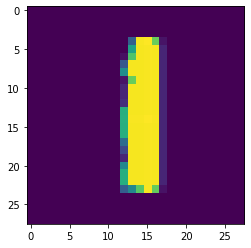

In [106]:

g = plt.imshow(X_train[0][:,:,0])
print(Y_train[0])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


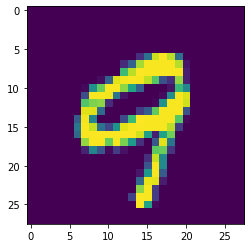

In [107]:
g = plt.imshow(X_train[2][:,:,0])
print(Y_train[2])

### 3. CNN 

In [108]:

# CNN architechture followed is -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [122]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [110]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [111]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### 3.1 Data Augmentation

In [132]:
##### We use data augmentation to prevent overfitting and boost accuracy

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [133]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=86),
                              epochs = 2, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 86
                              , callbacks=[learning_rate_reduction])

Epoch 1/2
439/439 - 134s - loss: 0.0689 - accuracy: 0.9797 - val_loss: 0.0326 - val_accuracy: 0.9910
Epoch 2/2
439/439 - 138s - loss: 0.0651 - accuracy: 0.9809 - val_loss: 0.0323 - val_accuracy: 0.9910


### 4. Confusion Matrix

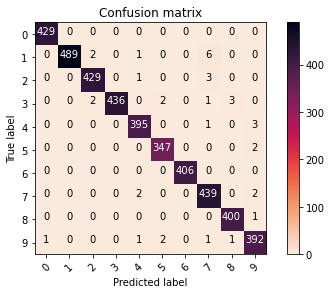

In [134]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10),cmap="rocket_r") 

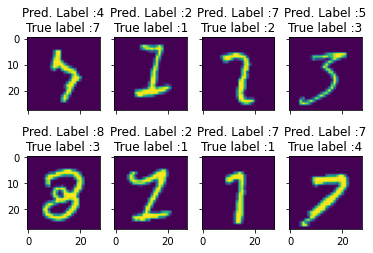

In [135]:

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 4
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Pred. Label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 8 errors 
most_important_errors = sorted_dela_errors[-8:]

# Show the top 8 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [136]:
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [121]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv(r"......\submission.csv",index=False)